In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [203]:
sql_pw='******'

In [200]:
#function to run simple SQL query from python
def create_table_from_SQL(user, database, password, query):
    '''
    - A function that returns a pandas dataframe from a SQL query in python
    ---------------
    - user: user for your local SQL connection in string format
    - database: schema name where your database is stored in string format
    - password: password to access your local SQL connection in string format
    - query: SQL query in string format; enclose with double quotes and use single quotes
    to designate VARCHAR values within queries; use schema_name.table_name after FROM statement
    '''
    import mysql.connector
    cnx = mysql.connector.connect(user=user, database=database, password=password)
    cursor = cnx.cursor()
    query = query
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = cursor.column_names
    return df

In [5]:
#modified version of Bettina's function which creates downsampled dataset for specific defects
#vs overall NICU admissions

def downsample_df (df, variable):

    '''
    Remove undefined information on defect presence admissions (defect == 'U'),
    create a binary target vector, and create a "balanced" dataframe
    with all defect cases and matching numbers of randomly selected non-defect cases.
    --------------------
    df: full dataframe
    variable: variable or defect of interest in string format
    '''

    # remove unknown class from df
    df_no_unknown = df[df[variable].isin(['Y', 'N'])]

    # Create binary target vector, NICU = yes classified as class 0
    df_y_n = pd.DataFrame(np.where((df_no_unknown[variable] == 'Y'), 0, 1))

    # Get indicies of each class' observations
    index_class0 = np.where(df_y_n == 0)[0]
    index_class1 = np.where(df_y_n == 1)[0]

    # Get numbers of observations in class 0
    n_class0 = len(index_class0)

    # Randomly sample the same number of observations from class 1 as in class 0, without replacement
    np.random.seed(0)
    index_class1_downsampled = np.random.choice(index_class1, size=n_class0, replace=False)

    # Create dataframes for NICU and downsampled non-NICU
    df_defect = df_no_unknown.iloc[index_class0]
    df_adj_NONdefect = df_no_unknown.iloc[index_class1_downsampled]

    # Append into 1 dataframe
    df_downsampled = df_defect.append(df_adj_NONdefect)

    return df_downsampled

In [7]:
# function to split out holdout test set
def split_sets(dataframe, seed, test_prop=0.1): 
    '''
    - A function that splits specifically a dataframe into a train and test portion
    - Requires multiple assignment: train, test
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    train = dataframe.iloc[trainIdxes,:]
    test  = dataframe.iloc[testIdxes,:]
    
    return train, test

In [3]:
def mlp_convert_cont_floats(df):
    #convert continuous variables to float
    #update to split out ordinal categorical separately
    for x in variables['continuous']:
        df[x]=df[x].astype('float')
    return df

def mlp_convert_nom_cat(df):
    #convert nominal categorical variables to category
    for x in variables['nominal_categorical']:
        df[x]=df[x].astype('category')
    return df

def mlp_convert_ord_cat(df):
    #convert ordinal categorical variables
    df.DOB_MM = df.DOB_MM.astype('category')
    df.PRECARE = df.PRECARE.astype('float')
    return df

def mlp_fill_MAR_blanks(df):
    #change true nulls to fit missingness definitions already in the dataset
    df.isnull().sum()
    df.MAR_P = df.MAR_P.fillna(value='U')
    df.DMAR = df.DMAR.fillna(value=9)
    df.DMAR.replace('',9, inplace=True) # need to take care of 1 vs '1'
#     df.DMAR.replace('1',1, inplace=True)
#     df.DMAR.replace('2',2, inplace=True)
    return df

def mlp_reassign_FRACE(df):
    #combine FRACEHISP unknowns columns
    df.FRACEHISP = df.FRACEHISP.replace(8,9)
    return df

def mlp_reassign_X_NA(df):
    #assign 'X' to 'N' for RF_FEDRG RF_ARTEC and 'Y' for MAR_P since paternity assumed for married
    for x in ['RF_FEDRG', 'RF_ARTEC']:
        df[x].replace('X','N', inplace=True)
    df.MAR_P.replace('X','Y', inplace=True)
    return df

def mlp_reassign_ILs(df):
    #assign 888 to mean for ILLB_R and ILP_R
    for x in ['ILLB_R', 'ILP_R', 'ILOP_R']:
        df[x].replace(888,df.MAGER*12, inplace=True)
    return df


In [4]:
def measure_missing(df, target):
    #create table of missingness proportions
    missing_props = pd.DataFrame()
    for i in range(0,len(missing_vals)):
        temp = df.groupby(target)[missing_dict[list(missing_dict.keys())[i]]].apply\
        (lambda x: np.sum(x==missing_vals[i])/(df.shape[0]/2))
        missing_props = pd.concat([missing_props, temp], axis=1)   

    #create lists of variables with high missingness vs. low missingness
    large_miss = list(missing_props.columns[missing_props.apply(lambda x: sum(x)>0.1, axis=0)])
    small_miss = list(missing_props.columns[missing_props.apply(lambda x: sum(x)<0.1, axis=0)])

    #sort low missingness categorical variables into types
    small_cats = {'cat3': [], 'cat8': [], 'cat9': [], 'catU': []}

    for var in small_miss:
        if var in missing_dict['cat3']:
            small_cats['cat3'].append(var) 
        elif var in missing_dict['cat8']:
            small_cats['cat8'].append(var)
        elif var in missing_dict['cat9']:
            small_cats['cat9'].append(var)
        elif var in missing_dict['catU']:
            small_cats['catU'].append(var)    


    #sort low missingness continuous variables
    small_conts = {'cont9': [], 'cont99': [], 'cont999': [], 'cont99.9': []}

    for var in small_miss:
        if var in missing_dict['cont9']:
            small_conts['cont9'].append(var) 
        elif var in missing_dict['cont99']:
            small_conts['cont99'].append(var)
        elif var in missing_dict['cont999']:
            small_conts['cont999'].append(var)
        elif var in missing_dict['cont99.9']:
            small_conts['cont99.9'].append(var)
    return small_conts, small_cats, large_miss



In [5]:
def mlp_impute_s_cat(df,df_w,small_cats):
    #mode imputation of categoricals with low missingness
    small_vals = [3,8,9,'U']
    for i in range(0, len(small_vals)):
        temp_lis = small_cats[list(small_cats.keys())[i]]
        for x in temp_lis:
            major_cat = df_w[x].value_counts().sort_values(ascending=False).index[0]
            df[x]=df[x].replace(small_vals[i],major_cat)
    return df

def mlp_impute_s_num(df,df_w,small_conts):
    #median imputation of categoricals with low missingness
    #statistical significance of relationship with target imnproves on variable by variable basis after 
    #median imputation
    csmall_vals = [9,99,999,99.9]
    for i in range(0, len(csmall_vals)):
        temp_lis = small_conts[list(small_conts.keys())[i]]
        for x in temp_lis:
            df[x]=df[x].replace(csmall_vals[i],df_w[x].median())
    return df


def binarize9(x):
    if x==9:
        return 1
    else:
        return 0
    
def binarize99(x):
    if x==99:
        return 1
    else:
        return 0

def binarize999(x):
    if x==999:
        return 1
    else:
        return 0

    
def mlp_impute_FAGECOMB(df,df_w):
    #Impute FAGECOMB missing vals and store whether column was imputed    
    df['FAGECOMB_IMP'] = df.FAGECOMB.apply(lambda x: binarize99(x))
    df.FAGECOMB.replace(99, df_w.FAGECOMB.median(),inplace = True)
    return df

def mlp_impute_ILPs(df,df_w):
    #Impute ILOP_R and ILP_R missing vals and store whether column was imputed
    for x in ['ILOP_R', 'ILP_R']:
        df[x+'_IMP'] = df[x].apply(lambda x: binarize999(x))
    for x in ['ILOP_R', 'ILP_R']:
        df[x].replace(999,df_w[x].median(), inplace=True)
    return df

def mlp_impute_FRACE_ED(df,df_w):
    #Impute FRACEHISP and FEDUC missing vals and store whether column was imputed
    for x in ['FRACEHISP', 'FEDUC']:
        df[x+'_IMP'] = df[x].apply(lambda x: binarize9(x))
    for x in ['FRACEHISP', 'FEDUC']:
        df[x].replace(9,df_w[x].mode()[0], inplace=True)
    return df

def mlp_impute_combine(df):
    #Combine imputed flag columns into one
    import re
    imputed_col = list(filter(lambda i: re.search('_IMP',i), df.columns))
#     print(len(imputed_col))
    if len(imputed_col)==0:
        return df
    df['lrg_miss_imp']= [1 if sum(df.loc[i,imputed_col])==1 else 0 for i in range(len(df))]
    df.drop(columns = imputed_col, inplace=True)
    return df

In [6]:
def mlp_all_of_the_above(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
    df = mlp_reassign_FRACE(df)
    df = mlp_reassign_X_NA(df)
    df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
    small_conts, small_cats, large_miss = measure_missing(df,target)
    df = mlp_impute_s_cat(df,df_w,small_cats)
    df = mlp_impute_s_num(df,df_w,small_conts)
    df = mlp_impute_FAGECOMB(df,df_w)
    df = mlp_impute_ILPs(df,df_w)
    df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [7]:

#dummfiy columns

def dummify_columns(dataframe,var_list):
    '''
    dummifies a columns, merges with the dataframe, and drops the non-dummified column
    ------------
    dataframe: full dataframe
    variable: column name as string
    '''
    for vr in var_list:
        dummified_feature = pd.get_dummies(dataframe[vr], prefix=vr,drop_first=True,prefix_sep='__')
        dataframe = pd.concat([dataframe,dummified_feature],axis=1,sort=False)
    dataframe.drop(columns = var_list, inplace = True)
    return dataframe

In [24]:
def add_random_column_to_df (dataframe):
    import random
    mylist = []
    for i in range(0,dataframe.shape[0]):
        x = random.randint(1,1000)
        mylist.append(x)
    dataframe['RANDOM'] = mylist

    return dataframe

In [8]:
def continuous_VIF(df, target,exclude_=[]):
    from sklearn.linear_model import LinearRegression
    import matplotlib.pyplot as plt
    
    #Identify continuous variables
    cont_vars = list(set(df.select_dtypes(exclude ='category').columns) - set([target]) - set(exclude_))
    
    #Drop features 
    df_no_bs =df.drop(columns = exclude_)
    
    #Label encode and prep for multiple linear regression
    dummified = dummify_columns(df_no_bs,list(set(df.select_dtypes(include ='category').columns)-set(exclude_)))
    target = dummified[[target]]
    features = dummified.loc[:,set(dummified.columns) - set(target)]
    
    vif_list=[]
    
    for i in cont_vars:
        lm = LinearRegression()
        lm.fit(features.loc[:,features.columns != i],features[i])
        vif_list += [[i, 1/(1-lm.score(features.loc[:,features.columns != i],features[i]))]]
    vif_cont = pd.DataFrame(vif_list, columns=['feature','vif']).sort_values('vif', ascending = False)\
    .reset_index().drop(columns='index')
    
    #Display VIF > 1.5
    cut_off=max(vif_cont[vif_cont['vif']>1.5].index)
    plt.xticks(rotation = 90)
    plt.bar(vif_cont.loc[:cut_off,'feature'],vif_cont.loc[:cut_off,'vif'])
    
    return vif_cont.loc[:cut_off,['feature','vif']]

In [10]:
#pull selected variables from 2016-2018 databases in SQL and append to a single dataframe
query18 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,\
                RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,\
                IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,\
                LBO_REC,TBO_REC,ILLB_R,ILOP_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,\
                RF_CESARN,OEGest_Comb,CA_CCHD\
         FROM cdc.us2018"

query17 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,\
                RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,\
                IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,\
                LBO_REC,TBO_REC,ILLB_R,ILOP_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,\
                RF_CESARN,OEGest_Comb,CA_CCHD\
         FROM cdc.us2017"

query16 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,\
                RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,\
                IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,\
                LBO_REC,TBO_REC,ILLB_R,ILOP_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,\
                RF_CESARN,OEGest_Comb,CA_CCHD\
         FROM cdc.us2016"


In [32]:
queries = [query18, query17, query16]
            
cchd = pd.DataFrame()
test_cchd = pd.DataFrame()

for query in queries:
    temp = create_table_from_SQL('root','cdc',sql_pw, query)
    train, test = split_sets(temp, 0, test_prop=0.1)
    train = downsample_df(train, 'CA_CCHD')
    cchd = cchd.append(train)  
    test_cchd = test_cchd.append(test)

In [9]:
# begin dictionary of columns to analyze for CCHD - includes pre-pregnancy and gestational features
# features re: delivery and labor are not useful for this use case
variables = {'nominal_categorical':['MBSTATE_REC','MRACEHISP','MAR_P','DMAR','MEDUC','FRACEHISP',\
                                    'FEDUC','WIC','RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE',\
                                    'RF_EHYPE','RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR',\
                                  'IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC', 'PAY', 'SEX'],\
           'ordinal_categorical':['PRECARE', 'DOB_MM'],\
           'continuous':['MAGER', 'FAGECOMB','PRIORTERM','PRIORLIVE','PRIORDEAD','LBO_REC','TBO_REC',\
                         'ILLB_R','ILOP_R','ILP_R','PREVIS','CIG_0','CIG_1','CIG_2','CIG_3','M_Ht_In','BMI',\
                         'WTGAIN','RF_CESARN','OEGest_Comb'],\
            'target':['CA_CCHD']}

In [10]:
#create missingness types:
missing_dict = {'cont9': ['LBO_REC', 'TBO_REC'],\
                'cont99': ['FAGECOMB', 'PRIORTERM','PRIORLIVE', 'PRIORDEAD', 'PRECARE', 'PREVIS',\
                         'CIG_0', 'CIG_1', 'CIG_2', 'CIG_3', 'M_Ht_In', 'WTGAIN', 'RF_CESARN', 'OEGest_Comb'],\
                'cont999':['ILLB_R', 'ILP_R', 'ILOP_R'],\
                'cont99.9': ['BMI'],\
                'cat3': ['MBSTATE_REC'],\
                'cat8': ['MRACEHISP'],\
                'cat9': ['MEDUC', 'FEDUC', 'PAY', 'FRACEHISP', 'DMAR'],\
                'catU': ['WIC','RF_PDIAB','RF_GDIAB','RF_PHYPE',\
                        'RF_GHYPE','RF_EHYPE','RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR','IP_GON',\
                        'IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC', 'MAR_P']}
missing_vals = [9,99,999,99.9,3,8,9,'U']


In [26]:
#All Unknowns imputed with mode or median, replace IL's with age for first pregnancy
cchd = mlp_all_of_the_above(cchd,cchd,'CA_CCHD')

,feature,vif
0,LBO_REC,99.011612
1,PRIORLIVE,61.516602
2,TBO_REC,34.794279
3,CIG_2,9.951865
4,PRIORTERM,9.028880
5,CIG_1,7.891466
6,CIG_3,5.017719
7,ILLB_R,4.872194
8,ILP_R,4.262964
9,RF_CESARN,4.147368


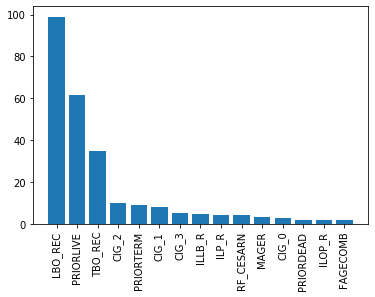

In [133]:
continuous_VIF(cchd,'CA_CCHD')

,feature,vif
0,MAGER,2.963879
1,CIG_0,2.753163
2,CIG_1,2.729374
3,PRIORLIVE,2.415134
4,FAGECOMB,1.923508
5,ILLB_R,1.828458
6,ILOP_R,1.629717
7,PRIORTERM,1.603020


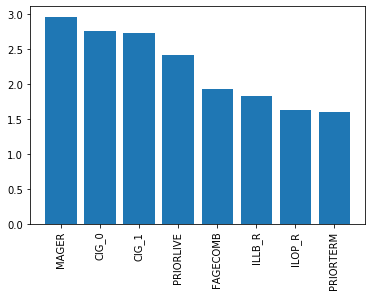

In [134]:
#Remove candidates with high multicollinearity
takeout = ['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R']
continuous_VIF(cchd,'CA_CCHD',takeout)

In [115]:
def mlp_no_conversions(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
    df = mlp_reassign_FRACE(df)
#     df = mlp_reassign_X_NA(df)
#     df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
#     small_conts, small_cats, large_miss = measure_missing(df,target)
#     df = mlp_impute_s_cat(df,df_w,small_cats)
#     df = mlp_impute_s_num(df,df_w,small_conts)
#     df = mlp_impute_FAGECOMB(df,df_w)
#     df = mlp_impute_ILPs(df,df_w)
#     df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [136]:
#Minimal conversion to eiminate blanks and no imputation
cchd_as_is = mlp_no_conversions(cchd2,cchd2,'CA_CCHD')

,feature,vif
0,CIG_1,27.542198
1,CIG_2,23.351493
2,TBO_REC,8.228516
3,LBO_REC,7.636964
4,FAGECOMB,7.072512
5,CIG_0,5.491004
6,RF_CESARN,4.671343
7,ILP_R,4.158168
8,ILLB_R,3.964412
9,CIG_3,3.035989


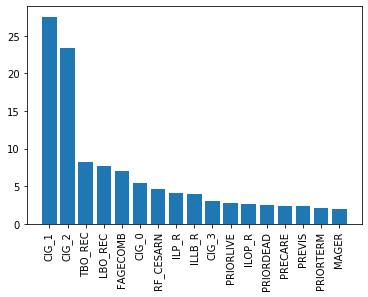

In [137]:
continuous_VIF(cchd_as_is,'CA_CCHD')

,feature,vif
0,FAGECOMB,7.068457
1,CIG_0,5.422131
2,CIG_1,5.415301
3,RF_CESARN,3.937551
4,PRIORDEAD,2.408584
5,PRECARE,2.393211
6,PRIORLIVE,2.375487
7,PREVIS,2.362284
8,PRIORTERM,1.739041
9,MAGER,1.732457


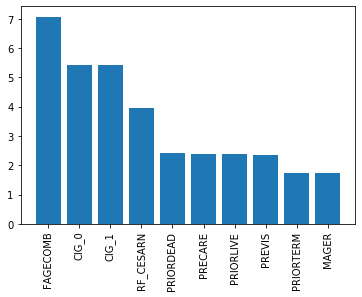

In [138]:
continuous_VIF(cchd_as_is,'CA_CCHD',['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R'])

In [96]:
def mlp_no_imputations(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
    df = mlp_reassign_FRACE(df)
    df = mlp_reassign_X_NA(df)
    df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
#     small_conts, small_cats, large_miss = measure_missing(df,target)
#     df = mlp_impute_s_cat(df,df_w,small_cats)
#     df = mlp_impute_s_num(df,df_w,small_conts)
#     df = mlp_impute_FAGECOMB(df,df_w)
#     df = mlp_impute_ILPs(df,df_w)
#     df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [139]:
#No imputations but some reassignments of values like IL's with age
cchd_no_imp = mlp_no_imputations(cchd3,cchd3,'CA_CCHD')

,feature,vif
0,CIG_1,27.543506
1,CIG_2,23.351631
2,ILP_R,8.582158
3,FAGECOMB,7.072521
4,TBO_REC,6.197669
5,LBO_REC,6.196616
6,ILOP_R,5.865331
7,CIG_0,5.492165
8,RF_CESARN,4.665473
9,ILLB_R,3.063947


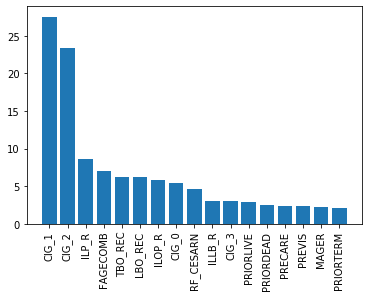

In [140]:
continuous_VIF(cchd_no_imp,'CA_CCHD')

,feature,vif
0,FAGECOMB,7.066782
1,CIG_0,5.422587
2,CIG_1,5.415092
3,RF_CESARN,3.920453
4,PRECARE,2.400315
5,PRIORDEAD,2.387310
6,PREVIS,2.362362
7,PRIORLIVE,2.313684
8,PRIORTERM,1.741481
9,MAGER,1.717884


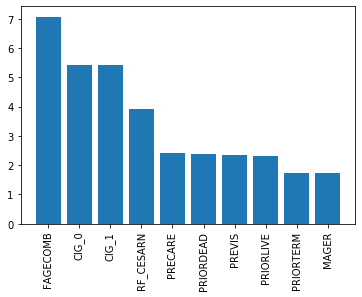

In [141]:
continuous_VIF(cchd_no_imp,'CA_CCHD',['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R'])

In [125]:
def mlp_no_conv_yes_imp(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
#     df = mlp_reassign_FRACE(df)
#     df = mlp_reassign_X_NA(df)
#     df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
    small_conts, small_cats, large_miss = measure_missing(df,target)
    df = mlp_impute_s_cat(df,df_w,small_cats)
    df = mlp_impute_s_num(df,df_w,small_conts)
    df = mlp_impute_FAGECOMB(df,df_w)
    df = mlp_impute_ILPs(df,df_w)
    df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [144]:
#Imputed with minimal reassignments
cchd_no_c_y_imp = mlp_no_conv_yes_imp(cchd4,cchd4,'CA_CCHD')

,feature,vif
0,LBO_REC,99.339936
1,PRIORLIVE,61.669292
2,TBO_REC,35.355997
3,CIG_2,9.953878
4,PRIORTERM,9.035194
5,CIG_1,7.893866
6,ILLB_R,5.223845
7,CIG_3,5.020074
8,ILP_R,4.499973
9,RF_CESARN,4.170336


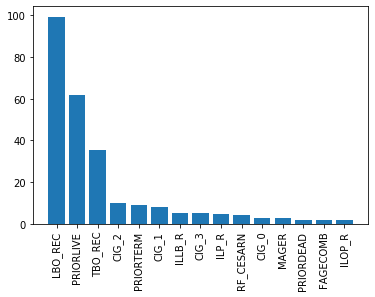

In [146]:
continuous_VIF(cchd_no_c_y_imp,'CA_CCHD')

,feature,vif
0,CIG_0,2.752940
1,CIG_1,2.730295
2,MAGER,2.590760
3,PRIORLIVE,2.288207
4,FAGECOMB,1.932715
5,ILLB_R,1.873501
6,PRIORTERM,1.517548


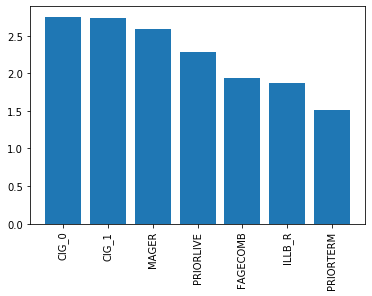

In [148]:
continuous_VIF(cchd_no_c_y_imp,'CA_CCHD',['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R'])

In [149]:
def mlp_no_conv_yes_imp_s(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
#     df = mlp_reassign_FRACE(df)
#     df = mlp_reassign_X_NA(df)
#     df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
    small_conts, small_cats, large_miss = measure_missing(df,target)
    df = mlp_impute_s_cat(df,df_w,small_cats)
    df = mlp_impute_s_num(df,df_w,small_conts)
#     df = mlp_impute_FAGECOMB(df,df_w)
#     df = mlp_impute_ILPs(df,df_w)
#     df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [151]:
#Imputed only "small" missing with minimal reassignments
cchd_no_c_y_imp_s = mlp_no_conv_yes_imp_s(cchd5,cchd5,'CA_CCHD')

,feature,vif
0,LBO_REC,98.402294
1,PRIORLIVE,61.584687
2,TBO_REC,34.981603
3,CIG_2,9.948444
4,PRIORTERM,9.027570
5,CIG_1,7.892241
6,FAGECOMB,7.032742
7,CIG_3,5.018440
8,RF_CESARN,4.169019
9,ILLB_R,3.590650


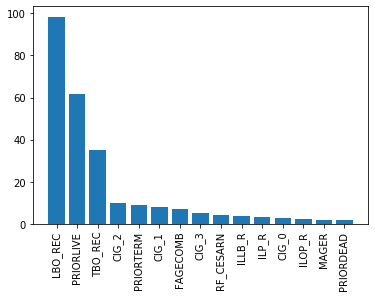

In [152]:
continuous_VIF(cchd_no_c_y_imp_s,'CA_CCHD')

,feature,vif
0,FAGECOMB,7.029488
1,CIG_0,2.753099
2,CIG_1,2.730682
3,PRIORLIVE,2.288351
4,MAGER,1.982438
5,ILLB_R,1.868617


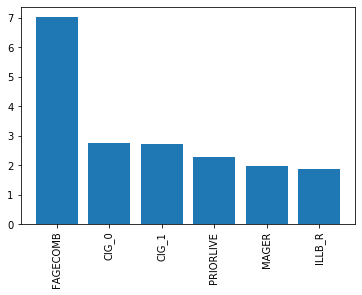

In [153]:
continuous_VIF(cchd_no_c_y_imp_s,'CA_CCHD',['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R'])

In [150]:
def mlp_no_conv_yes_imp_l(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
#     df = mlp_reassign_FRACE(df)
#     df = mlp_reassign_X_NA(df)
#     df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
    small_conts, small_cats, large_miss = measure_missing(df,target)
#     df = mlp_impute_s_cat(df,df_w,small_cats)
#     df = mlp_impute_s_num(df,df_w,small_conts)
    df = mlp_impute_FAGECOMB(df,df_w)
    df = mlp_impute_ILPs(df,df_w)
    df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [157]:
#Imputed only "large" missing with minimal reassignments
cchd_no_c_y_imp_l = mlp_no_conv_yes_imp_l(cchd6,cchd6,'CA_CCHD')

,feature,vif
0,CIG_1,27.547997
1,CIG_2,23.368742
2,TBO_REC,7.308316
3,LBO_REC,7.304217
4,CIG_0,5.490957
5,RF_CESARN,4.669100
6,ILP_R,3.289460
7,ILLB_R,3.273659
8,CIG_3,3.036197
9,PRIORLIVE,2.836761


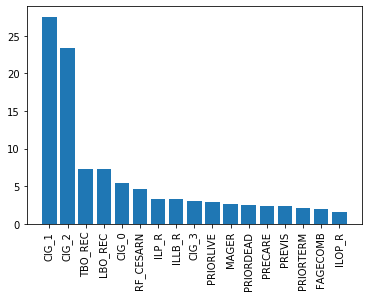

In [159]:
continuous_VIF(cchd_no_c_y_imp_l,'CA_CCHD')

,feature,vif
0,CIG_0,5.422446
1,CIG_1,5.415951
2,RF_CESARN,3.944807
3,PRIORDEAD,2.410046
4,PRECARE,2.394296
5,PRIORLIVE,2.379174
6,PREVIS,2.362142
7,MAGER,2.349430
8,FAGECOMB,1.932403
9,PRIORTERM,1.750552


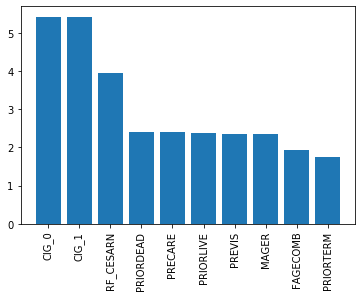

In [160]:
continuous_VIF(cchd_no_c_y_imp_l,'CA_CCHD',['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R'])

In [12]:
cchd7 = pd.read_csv('cchd_baseline.csv')

In [13]:
def mlp_no_ilp(df,df_w,target):
    df = mlp_fill_MAR_blanks(df)
    df = mlp_reassign_FRACE(df)
    df = mlp_reassign_X_NA(df)
#     df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
    small_conts, small_cats, large_miss = measure_missing(df,target)
    df = mlp_impute_s_cat(df,df_w,small_cats)
    df = mlp_impute_s_num(df,df_w,small_conts)
    df = mlp_impute_FAGECOMB(df,df_w)
    df = mlp_impute_ILPs(df,df_w)
    df = mlp_impute_FRACE_ED(df,df_w)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    df = mlp_impute_combine(df)
    return df

In [14]:
cchd_noilp=mlp_no_ilp(cchd7,cchd7,'CA_CCHD')

,feature,vif
0,LBO_REC,99.316688
1,PRIORLIVE,61.669526
2,TBO_REC,35.333082
3,CIG_2,9.952643
4,PRIORTERM,9.032218
5,CIG_1,7.890869
6,ILLB_R,5.219215
7,CIG_3,5.018314
8,ILP_R,4.497875
9,RF_CESARN,4.168373


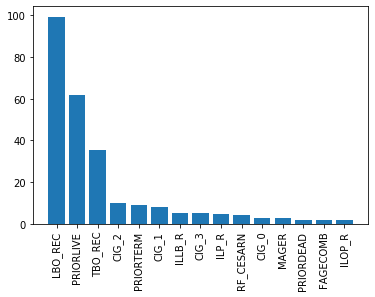

In [17]:
continuous_VIF(cchd_noilp,'CA_CCHD')

,feature,vif
0,CIG_0,2.753069
1,CIG_1,2.730172
2,MAGER,2.586748
3,PRIORLIVE,2.286858
4,FAGECOMB,1.923649
5,ILLB_R,1.874123
6,PRIORTERM,1.514930


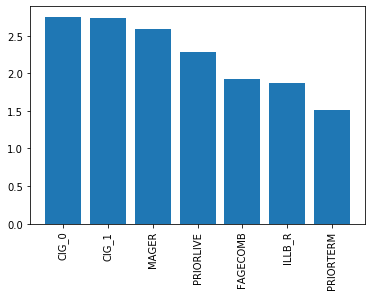

In [16]:
continuous_VIF(cchd_noilp,'CA_CCHD',['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR', 'CIG_2', 'CIG_3', 'ILP_R'])